In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

### 3. zadatak - usporedba s Tensorflowom

In [2]:
DATA_DIR = '/../datasets/MNIST/'

# load dataset
mnist = input_data.read_data_sets(DATA_DIR, one_hot=True)

Extracting /../datasets/MNIST/train-images-idx3-ubyte.gz
Extracting /../datasets/MNIST/train-labels-idx1-ubyte.gz
Extracting /../datasets/MNIST/t10k-images-idx3-ubyte.gz
Extracting /../datasets/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
# parameters
image_layers = 1
image_height = 28
image_width = 28
num_classes = 10

conv_k = 5
pool_k = 2
hidden_layers = [16, 32, 512]

param_delta = 1e-4
param_niter = 20000
print_every = 1000
batch_size = 50

w_stdev = 0.1
b_initial = 0.1

In [4]:
def weight_variable(shape):
    # shape [dim_x, dim_y, num_of_input_channels, num_of_output_channels]
    initial = tf.truncated_normal(shape, stddev=w_stdev)
    return tf.Variable(initial)

def bias_variable(shape):
    # shape: [num_of_output_channels]
    initial = tf.constant(b_initial, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    # x: input
    # W: weights
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool(x):
    # x: input
    return tf.nn.max_pool(x, ksize=[1, pool_k, pool_k, 1], strides=[1, pool_k, pool_k, 1], padding='SAME')

# inputs
x = tf.placeholder(tf.float32, shape=[None, image_height * image_width])
x_image = tf.reshape(x, [-1, image_height, image_width, image_layers])
y_ = tf.placeholder(tf.float32, shape=[None, num_classes])

# conv layer
W_conv1 = weight_variable([conv_k, conv_k, image_layers, hidden_layers[0]])
b_conv1 = bias_variable([hidden_layers[0]])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool(h_conv1)

# conv layer
W_conv2 = weight_variable([conv_k, conv_k, hidden_layers[0], hidden_layers[1]])
b_conv2 = bias_variable([hidden_layers[1]])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool(h_conv2)

# fc layer
W_fc1 = weight_variable([7*7*hidden_layers[1], hidden_layers[2]])
b_fc1 = bias_variable([hidden_layers[2]])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*hidden_layers[1]])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# readout layer
W_fc2 = weight_variable([hidden_layers[2], num_classes])
b_fc2 = bias_variable([num_classes])

y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2

# loss
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

# optimizer
train_step = tf.train.AdamOptimizer(param_delta).minimize(cross_entropy)

# accuracy
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# init session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(param_niter):
    batch = mnist.train.next_batch(batch_size)
    _ = sess.run(train_step, feed_dict={x: batch[0], y_: batch[1]})

    if i % print_every == 0:
        train_accuracy = sess.run(accuracy, feed_dict={x: batch[0], y_: batch[1]})
        print('step %d, training accuracy %g' % (i, train_accuracy))

test_accuracy = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
print('test accuracy %g' % test_accuracy)

step 0, training accuracy 0.1
step 1000, training accuracy 0.98
step 2000, training accuracy 0.98
step 3000, training accuracy 0.96
step 4000, training accuracy 0.96
step 5000, training accuracy 0.96
step 6000, training accuracy 0.96
step 7000, training accuracy 0.98
step 8000, training accuracy 1
step 9000, training accuracy 0.98
step 10000, training accuracy 1
step 11000, training accuracy 1
step 12000, training accuracy 1
step 13000, training accuracy 1
step 14000, training accuracy 1
step 15000, training accuracy 1
step 16000, training accuracy 1
step 17000, training accuracy 1
step 18000, training accuracy 1
step 19000, training accuracy 1
test accuracy 0.9905


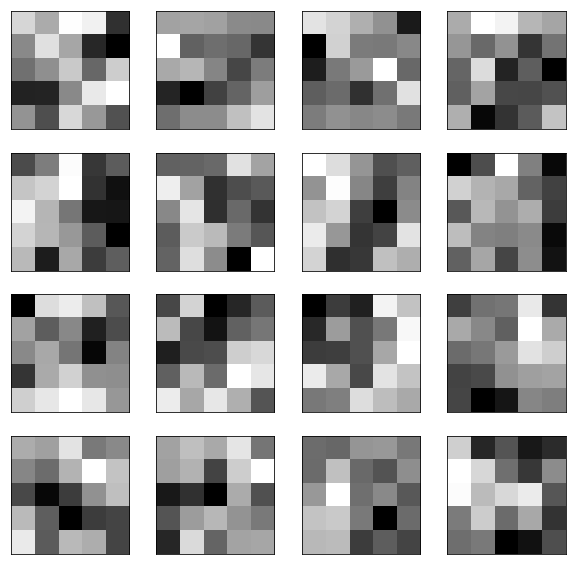

In [23]:
_, plots = plt.subplots(4, 4, figsize=(10, 10))
for i, plot in enumerate(plots.flatten()):
    feature = sess.run(W_conv1)[:,:,0,i]
    vmin = feature.flatten().min()
    vmax = feature.flatten().max()
    plot.matshow(feature, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
    plot.set_xticks([])
    plot.set_yticks([])
plt.show()